<a href="https://colab.research.google.com/github/borisevstratov/homeworkHSM/blob/master/nlip_hw3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3: BBC Text classification
*Boris Evstratov*

## Task:
Classify news to one of 5 categories based on text
1. Choose and argue your measure of a test's accuracy;
2. Build data processing and classification pipeline;
3. Tune  your model.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models


# This code was tested with the following version of TensorFlow
print("TensorFlow version", tf.__version__)

TensorFlow version 1.13.1


In [2]:
# Load the dataset
data = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")
data.tail()


,category,text
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


In [0]:
# Get a number of each category occurences in the dataset
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [3]:
# Calculate test and train sample sizes
train_size = int(len(data) * .8)
test_size = len(data) - train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

Train size: 1780
Test size: 445


In [0]:
# Define a function for splitting the data into test and training sets
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [0]:
# Split the data into test and training sets
train_cat, test_cat = train_test_split(data['category'], train_size)
train_text, test_text = train_test_split(data['text'], train_size)


In [0]:
# Create a tokenizer object
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)


In [0]:
# Fit with tokenizer with the training text data
tokenize.fit_on_texts(train_text) 
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [0]:
# Convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [0]:
# Convert the labels to a one-hot encoding
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
# Inspect the dimensions of the training and test data
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


In [0]:
# Define model training parameters
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [0]:
# Building the model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# Training the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1602 samples, validate on 178 samples
Epoch 1/2
1602/1602 [==============================] - 0s 309us/sample - loss: 0.0117 - acc: 1.0000 - val_loss: 0.1161 - val_acc: 0.9494
Epoch 2/2
1602/1602 [==============================] - 1s 316us/sample - loss: 0.0063 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 0.9494


In [20]:
# Evaluate the accuracy of the trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

445/445 [==============================] - 0s 89us/sample - loss: 0.1295 - acc: 0.9618
Test loss: 0.12951066879074224
Test accuracy: 0.9617978


In [0]:
# Define a function to expirement with the model's adjusted parameters
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [23]:
# Run a single experiment
batch_size = 20
epochs = 5
drop_ratio = 0.35
run_experiment(batch_size, epochs, drop_ratio)

batch size: 20, epochs: 5, drop_ratio: 0.35
	Test loss: 0.12537436044952843
	Test accuracy: 0.95955056


In [24]:
# Run a series of experiments, adjusting model parameters on each iteration
for batch_size in range(10,31,10):
  for epochs in range(3,15,5):
    for drop_ratio in np.linspace(0.1, 0.5, 3):
      run_experiment(batch_size, epochs, drop_ratio)

batch size: 10, epochs: 3, drop_ratio: 0.1
	Test loss: 0.12437001090454922
	Test accuracy: 0.95730335
batch size: 10, epochs: 3, drop_ratio: 0.30000000000000004
	Test loss: 0.1624865521980303
	Test accuracy: 0.952809
batch size: 10, epochs: 3, drop_ratio: 0.5
	Test loss: 0.14943099831325118
	Test accuracy: 0.952809
batch size: 10, epochs: 8, drop_ratio: 0.1
	Test loss: 0.12418579448830713
	Test accuracy: 0.96629214
batch size: 10, epochs: 8, drop_ratio: 0.30000000000000004
	Test loss: 0.13959724731152104
	Test accuracy: 0.9617978
batch size: 10, epochs: 8, drop_ratio: 0.5
	Test loss: 0.13812059320619308
	Test accuracy: 0.95730335
batch size: 10, epochs: 13, drop_ratio: 0.1
	Test loss: 0.1318263961814849
	Test accuracy: 0.9617978
batch size: 10, epochs: 13, drop_ratio: 0.30000000000000004
	Test loss: 0.1439427961296143
	Test accuracy: 0.95955056
batch size: 10, epochs: 13, drop_ratio: 0.5
	Test loss: 0.1390916228904572
	Test accuracy: 0.95730335
batch size: 20, epochs: 3, drop_ratio: 0.

In [26]:
# Generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(7):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label + "\n")  


hobbit picture  four years away  lord of the rings ...
Actual label:entertainment
Predicted label: entertainment

game firm holds  cast  auditions video game firm b ...
Actual label:tech
Predicted label: tech

clarke plans migrant point scheme anyone planning  ...
Actual label:politics
Predicted label: politics

radcliffe will compete in london paula radcliffe w ...
Actual label:sport
Predicted label: sport

serena becomes world number two serena williams ha ...
Actual label:sport
Predicted label: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Actual label:tech
Predicted label: tech

algeria hit by further gas riots algeria suffered  ...
Actual label:business
Predicted label: business



In [0]:
# Visualize the confusion matrix
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
# This utility function is from the sklearn docs
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

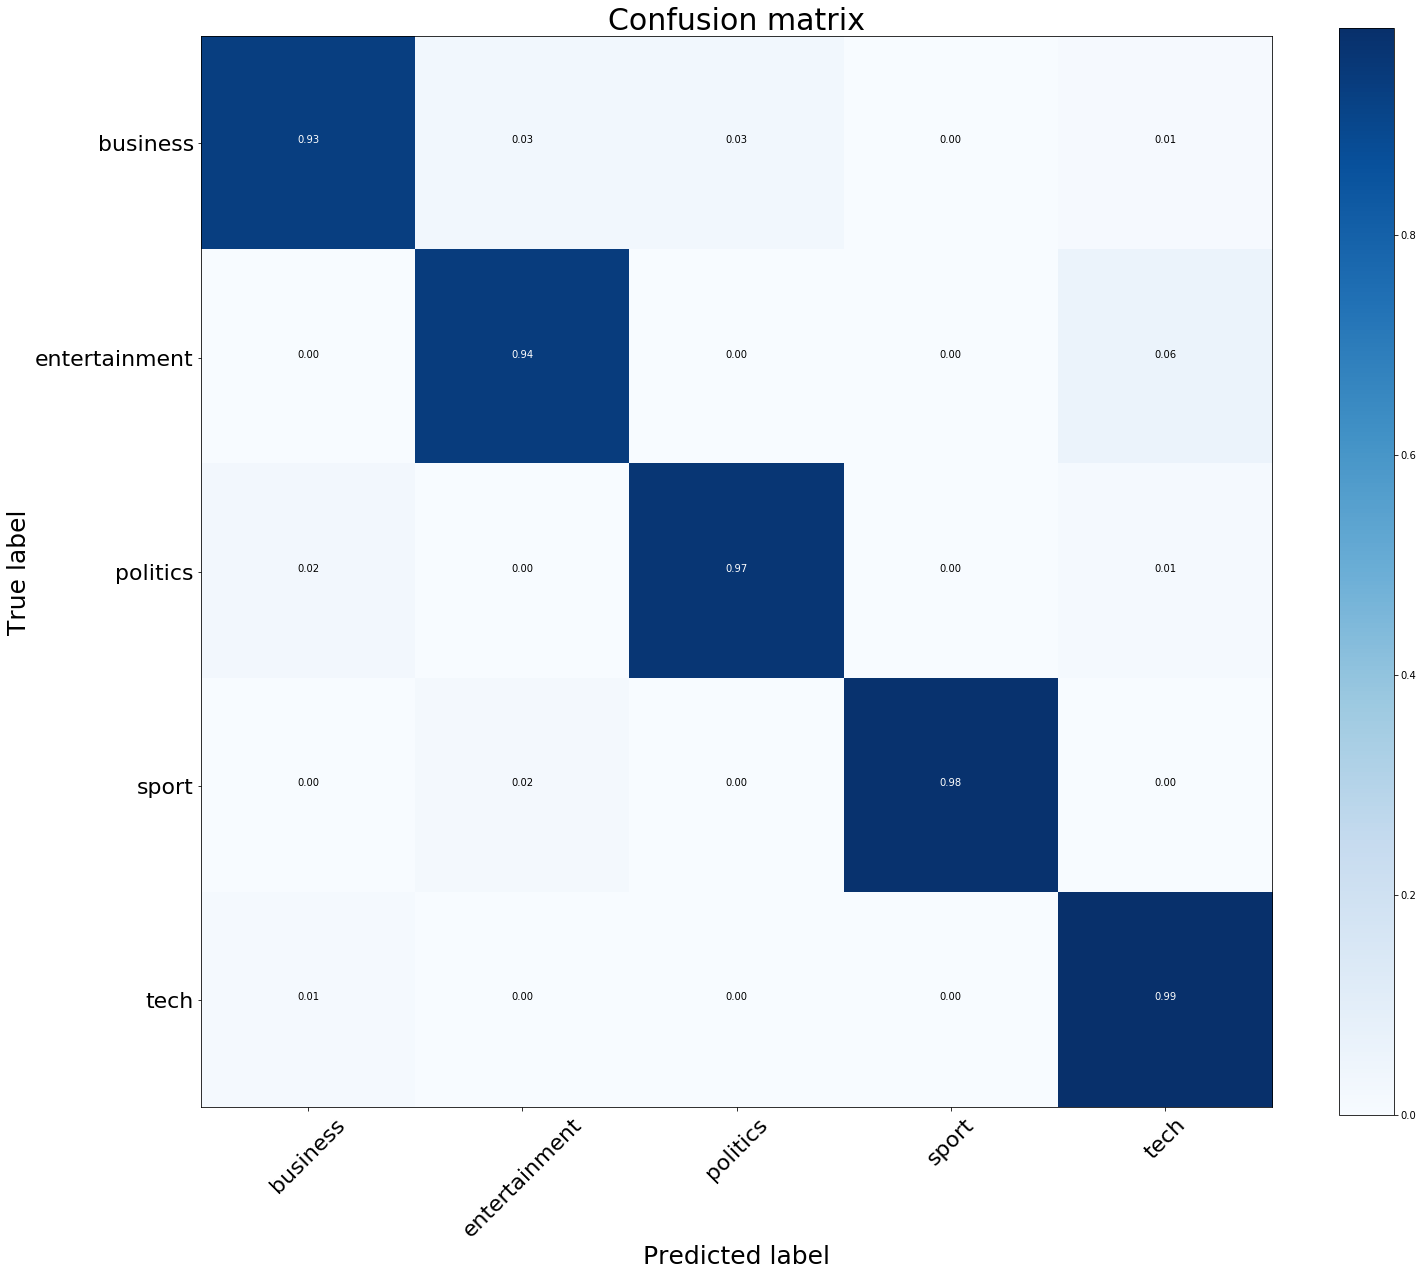

In [40]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()